# Hidden Physics Model (HPM) in TorchPhysics

HPM is deep learning approach, introduced in [1], for discovering nonlinear partial differential equations from scattered and potentially noisy observations in space and time. The approach uses two deep neural networks to approximate the unknown solution and nonlinear dynamics. 


The general form of a nonlinear PDE considered is 
$\frac{\partial}{\partial t} u(x,t) = \mathcal{N}(t,x,u,\partial_x u(x,t), \partial_x^2 u(x,t), ...)$
Where $\mathcal{N}$ is a nonlinear function of time t, space x, solution u and its derivatives. The first network approximates u(x,t) and acts as a prior on the unknown solution and to access numerical differentiations using automatic diverentiation. The second network represents the nonlinear dynamics $\mathcal{N}$ and helps to uncover that govern equation of a given spatiotemporal data-set. The two networks can be trained together or alternativly in a sequential manner, which improves the results and reduces training time. Once the HPM-Model of $\mathcal{N}$ is trained, it can be used to e.g. extrapolate in time or to new initial conditions using e.g. the PINN methodology. 

Following the example of [1] for discovering the Burger Equation is introduced.

The Burgers Equation used is in one space dimension with the given initial condition:

$$
\begin{cases}
\frac{\partial}{\partial t} u(x,t) &= -u(x,t)\partial_x u(x,t) + 0.1 \partial_x^2 u(x,t) &&\text{ on } [-8,8]\times [0,10], \\
u(x, 0) &= -sin(\pi x/8) &&\text{ on } [-8,8]\times \{0\}\\
\end{cases}
$$

A periodic boundary condition is used.



[1] https://arxiv.org/pdf/1801.06637.pdf

## Importing Libraries 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import torchphysics as tp
import numpy as np
import torch
import pytorch_lightning as pl
import scipy.io
import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from torchphysics.problem.conditions.condition import  DataCondition, HPM_EquationLoss_at_Sampler

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
RANDOM_SEED = 2308
np.random.seed(RANDOM_SEED)


__Python VERSION: 3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]
__pyTorch VERSION: 1.13.1
__CUDA VERSION
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


### Example-1 

### Reference Data  

In [3]:

data_sine = scipy.io.loadmat('burgers_sine.mat')
t = data_sine['t'].flatten()[:,None]
x = data_sine['x'].flatten()[:,None]
TT, XX = np.meshgrid(t,x)
X_star = np.hstack((TT.flatten()[:,None], XX.flatten()[:,None]))
u_soln = np.real(data_sine['usol'])
u_soln_v = u_soln.flatten()[:,None]
u_tensor = torch.tensor(u_soln_v,dtype=torch.float32)
X_tensor = torch.tensor(X_star,dtype=torch.float32)


In [4]:
axis_interval = 5
x_lbl = x.flatten()
y_lbl = t.flatten()
xpoints = list(np.arange(0,len(x_lbl),len(x_lbl)//axis_interval))
xpoints.append(len(x_lbl)-1)
ypoints = list(np.arange(0,len(y_lbl),len(y_lbl)//axis_interval))
ypoints.append(len(y_lbl)-1)
x_label_list = list(map( lambda x :round(x,2),[x_lbl[val] for val in xpoints]))
y_label_list = list(map( lambda x :round(x,2),[y_lbl[val] for val in ypoints]))


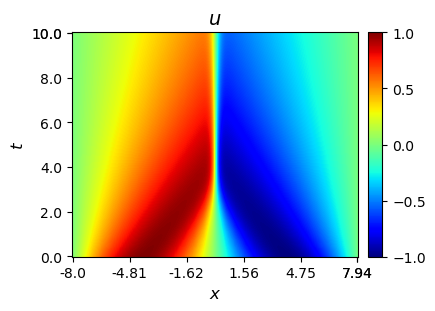

In [5]:

fig, ax = plt.subplots(1,figsize=(4,4))
ax1 = ax
im1 = ax1.imshow(u_soln.T,cmap='jet',origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xlabel('$x$',fontsize=12)
ax1.set_ylabel('$t$',fontsize=12)
ax1.set_xticks(xpoints)
ax1.set_xticklabels(x_label_list)
ax1.set_yticks(ypoints)
ax1.set_yticklabels(y_label_list)
ax1.set_title('$u$',fontsize=14)
plt.show()

### Training data

In [6]:
train_data = 2500

In [7]:
idx = np.random.choice(len(X_star), train_data, replace=False)
X_train_tensor = X_tensor[idx]
u_train_tensor = u_tensor[idx]

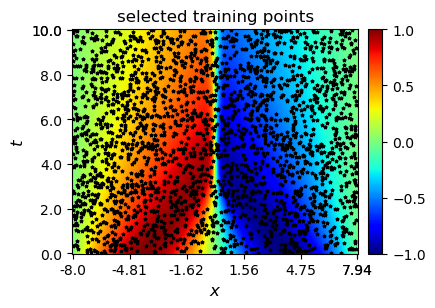

In [8]:
fig, ax = plt.subplots(1,figsize=(4,4))
ax1 = ax
im1 = ax1.imshow(u_soln.T,cmap='jet',origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xlabel('$x$',fontsize=12)
ax1.set_ylabel('$t$',fontsize=12)
ax1.set_xticks(xpoints)
ax1.set_xticklabels(x_label_list)
ax1.set_yticks(ypoints)
ax1.set_yticklabels(y_label_list)
ax1.set_title('selected training points',fontsize=12)
ax1.scatter((X_train_tensor[:,1]+8.)/16.0*255,X_train_tensor[:,0]/10*200,c='k',marker='*',s=5)
plt.show()

### Defining input-output spaces 

In [9]:
X = tp.spaces.R1('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
I_phy = tp.spaces.Rn('I',3)
N_phy = tp.spaces.R1('N')

In [10]:
input_space_sol = T*X
output_space_sol = U
input_space_hid_phy = I_phy
output_space_hid_phy = N_phy

In [11]:
Omega = tp.domains.Interval(space=X, lower_bound=x.min(), upper_bound=x.max())
I = tp.domains.Interval(space=T, lower_bound=t.min(), upper_bound=t.max())
domain = I*Omega

In [12]:
N_coll = 10000 # number of collocation points to constrain equation

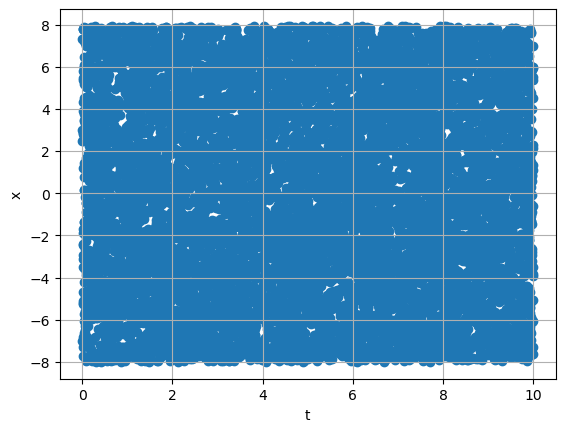

In [13]:
domain_sampler = tp.samplers.RandomUniformSampler(domain,n_points=N_coll)
plot = tp.utils.scatter(T*X, domain_sampler)

### Define solution Neural Network 
At this point, let us define the model $u:\overline{\Omega\times I}\to \mathbb{R}$.
A normalization layer is used and the scaled points will be passed through a fully connected network. The constructor requires to include the input space $T\times X$, output space $U$. 

In [14]:
normalization_layer = tp.models.NormalizationLayer(domain)
fcn_layer_sol = tp.models.FCN(input_space=input_space_sol,output_space=output_space_sol, hidden = (128,128,128))

Similar to Pytorch, the normalization layer and FCN can be concatenated by the class "tp.models.Sequential":

In [15]:
model_sol = tp.models.Sequential(normalization_layer, fcn_layer_sol)

### Data Condition
For training the first network, the DataCondition of torchphysics is used. The training data is converted into tp.spaces.Points and fed into a DataLoader. 
The DataLoader as well as defined NN are then used in the DataCondition.

In [16]:
input_train = tp.spaces.Points(torch.column_stack([X_train_tensor]), input_space_sol)
output_train = tp.spaces.Points(torch.column_stack([u_train_tensor]), output_space_sol)


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
batch_size_data = len(input_train)

data_loader = tp.utils.PointsDataLoader((input_train, output_train),batch_size=batch_size_data,shuffle=False,pin_memory = True)

data_condition  = DataCondition(module=model_sol,
                                dataloader=data_loader, 
                                norm=2,
                                use_full_dataset=False,
                                name="Data_Condition",
                                weight = 1)
                                                        

### Hidden physics condition 

In [19]:
fcn_layer_hid_phy = tp.models.FCN(input_space=input_space_hid_phy,output_space=output_space_hid_phy,hidden = (128,128))
model_hidden_phy = tp.models.Sequential(fcn_layer_hid_phy)

In [20]:
def quantities(t,x):
    
    u = model_sol(tp.spaces.Points(torch.column_stack((t, x)), input_space_sol))
    u = u.as_tensor
    grad_u_x = tp.utils.grad(u, x) 
    grad_u_xx = tp.utils.grad(grad_u_x, x) 
    grad_u_t = tp.utils.grad(u, t) 
    
    return u, grad_u_t, grad_u_x, grad_u_xx    


def hiddenPhysics(u, grad_u_x, grad_u_xx):
    
    
    input_model_hid = tp.spaces.Points(torch.column_stack((u,grad_u_x,grad_u_xx)),input_space_hid_phy) 
    output_model_hid = model_hidden_phy(input_model_hid)
    
    return output_model_hid.as_tensor


def residual_equation(t,x):
    
    u, grad_u_t, grad_u_x, grad_u_xx = quantities(t,x)
    output_hid_phy = hiddenPhysics(u, grad_u_x, grad_u_xx)
    residual = grad_u_t - output_hid_phy
    
    return residual



In [21]:
hidden_phy_condition =  HPM_EquationLoss_at_Sampler(module=model_hidden_phy,
                                           sampler=domain_sampler,
                                           residual_fn= residual_equation)


### Training model 

In [22]:
training_conditions = [data_condition,hidden_phy_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

In [23]:
epochs = 25000
trainer = pl.Trainer(gpus=1, max_steps=epochs, logger=True,benchmark=True)
trainer.fit(solver) 

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/ibp5kor/torchphyics_rtc_in/examples/hidden_physics/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 50.7 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
50.7 K    Trainable params
0         Non-trainable params
50.7 K    Total params
0.203     Total estima

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 0: 100%|█████████▉| 25000/25001 [04:57<00:00, 84.02it/s, loss=1.02e-05, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 25001/25001 [04:57<00:00, 84.02it/s, loss=1.02e-05, v_num=0]

`Trainer.fit` stopped: `max_steps=25000` reached.


Epoch 0: 100%|██████████| 25001/25001 [04:57<00:00, 84.02it/s, loss=1.02e-05, v_num=0]


### Prediction 

In [24]:
t_star , x_star = X_tensor[:,0:1]*1.0 , X_tensor[:,1:2]*1.0
t_star.requires_grad = True
x_star.requires_grad = True

In [25]:
u_pred, grad_u_t_pred, grad_u_x_pred, grad_u_xx_pred = quantities(t_star,x_star)

In [26]:
hidden_phy_pred = hiddenPhysics(u_pred, grad_u_x_pred, grad_u_xx_pred)

In [27]:
u_pred = u_pred.detach().numpy()
grad_u_t_pred = grad_u_t_pred.detach().numpy()
grad_u_x_pred = grad_u_x_pred.detach().numpy()
grad_u_xx_pred = grad_u_xx_pred.detach().numpy()
hidden_phy_pred  = hidden_phy_pred .detach().numpy()

In [28]:
# Calculating actual RHS equation
dx = x[1,0] - x[0,0]
eqn_true = []
for j in range(len(t)):
    temp_u = u_soln[:,j]
    temp_eqn = []
    for i in range(1,len(temp_u)):
        temp_u_l = temp_u[i-1]
        if i== len(temp_u)-1:
            temp_u_r = temp_u[0]
        else:
            temp_u_r = temp_u[i+1]
        temp_u_c = temp_u[i]
        temp_u_x = (temp_u_r - temp_u_l)/(2*dx)
        temp_u_xx = (temp_u_r + temp_u_l - 2*temp_u_c)/dx**2
        eqn_rhs = 0.1*temp_u_xx - temp_u[i]*temp_u_x
        temp_eqn.append(eqn_rhs)
    eqn_true.append(temp_eqn)
eqn_true = np.array(eqn_true)

In [29]:
eqn_pred = hidden_phy_pred.reshape(XX.shape).T[:,1:]
u_pred = u_pred.reshape(XX.shape)

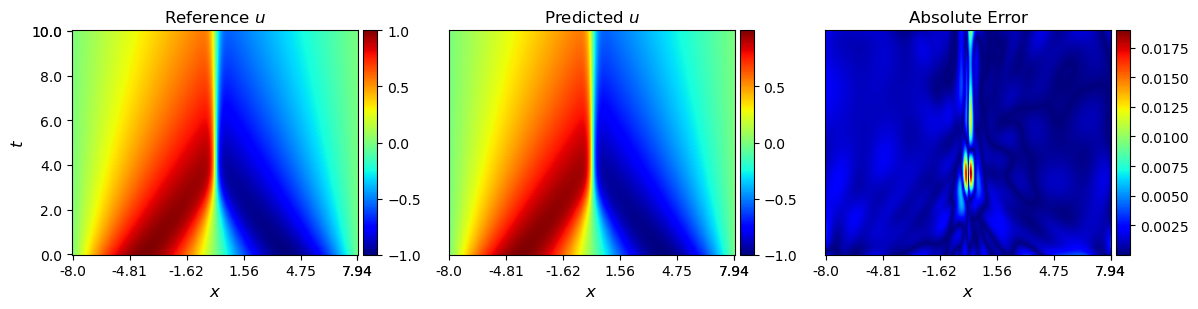

In [30]:
cmap = 'jet'#'seismic'
plt.figure(figsize=(12,3))
ax1 = plt.subplot(131)
im1 = ax1.imshow(u_soln.T,cmap=cmap,origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xlabel('$x$',fontsize=12)
ax1.set_ylabel('$t$',fontsize=12)
ax1.set_xticks(xpoints)
ax1.set_xticklabels(x_label_list)
ax1.set_yticks(ypoints)
ax1.set_yticklabels(y_label_list)
ax1.set_title('Reference $u$',fontsize=12)

ax2 = plt.subplot(132)
im2 = ax2.imshow(u_pred.T,cmap=cmap,origin='lower')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_xlabel('$x$',fontsize=12)
#ax2.set_ylabel('$t$',fontsize=12)
ax2.set_xticks(xpoints)
ax2.set_xticklabels(x_label_list)
ax2.set_yticks(ypoints)
ax2.set_yticklabels(y_label_list)
ax2.tick_params(left = False, labelleft = False) 
ax2.set_title('Predicted $u$',fontsize=12)

ax3 = plt.subplot(133)
im3 = ax3.imshow(np.abs(u_soln.T - u_pred.T),cmap=cmap,origin='lower')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im3, cax=cax, orientation='vertical')
ax3.set_xlabel('$x$',fontsize=12)
#ax3.set_ylabel('$t$',fontsize=12)
ax3.set_xticks(xpoints)
ax3.set_xticklabels(x_label_list)
ax3.set_yticks(ypoints)
ax3.set_yticklabels(y_label_list)
ax3.tick_params(left = False, labelleft = False) 
ax3.set_title('Absolute Error',fontsize=12)
plt.tight_layout()
plt.savefig('burgers_sol_pred.png',format='png')
plt.savefig('burgers_sol_pred.pdf',format='pdf')
plt.show()


In [31]:

def L2_ERROR(true_val,pred_val):
    
    return np.linalg.norm(true_val-pred_val,2)/np.linalg.norm(true_val,2)

def R2_SCORE(true_val,pred_val):
    
    mean_true = np.mean(true_val)
    
    return 1.0 - np.mean(np.square(true_val-pred_val))/np.mean(np.square(true_val-mean_true))


In [32]:
l2_error_u = L2_ERROR(u_soln.flatten(),u_pred.flatten())
r2_score_u = R2_SCORE(u_soln.flatten(),u_pred.flatten())
print('L2 Error u : ', l2_error_u)
print('R2 Score u : ', r2_score_u)

L2 Error u :  0.0027075328113528945
R2 Score u :  0.9999926692660754


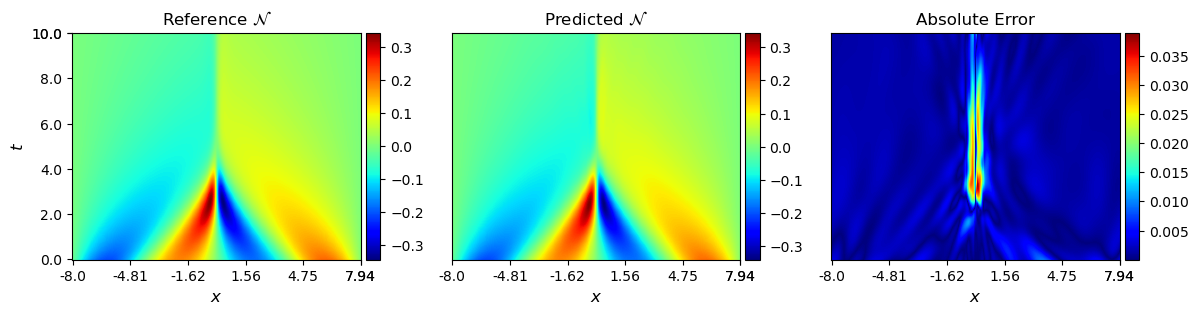

In [33]:
cmap = 'jet'#'seismic'
plt.figure(figsize=(12,3))
ax1 = plt.subplot(131)
im1 = ax1.imshow(eqn_true,cmap=cmap,origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xlabel('$x$',fontsize=12)
ax1.set_ylabel('$t$',fontsize=12)
ax1.set_xticks(xpoints)
ax1.set_xticklabels(x_label_list)
ax1.set_yticks(ypoints)
ax1.set_yticklabels(y_label_list)
ax1.set_title('Reference $\mathcal{N}$',fontsize=12)

ax2 = plt.subplot(132)
im2 = ax2.imshow(eqn_pred,cmap=cmap,origin='lower')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_xlabel('$x$',fontsize=12)
#ax2.set_ylabel('$t$',fontsize=12)
ax2.set_xticks(xpoints)
ax2.set_xticklabels(x_label_list)
ax2.set_yticks(ypoints)
ax2.set_yticklabels(y_label_list)
ax2.tick_params(left = False, labelleft = False) 
ax2.set_title('Predicted $\mathcal{N}$',fontsize=12)

ax3 = plt.subplot(133)
im3 = ax3.imshow(np.abs(eqn_true - eqn_pred),cmap=cmap,origin='lower')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im3, cax=cax, orientation='vertical')
ax3.set_xlabel('$x$',fontsize=12)
#ax3.set_ylabel('$t$',fontsize=12)
ax3.set_xticks(xpoints)
ax3.set_xticklabels(x_label_list)
ax3.set_yticks(ypoints)
ax3.set_yticklabels(y_label_list)
ax3.tick_params(left = False, labelleft = False) 
ax3.set_title('Absolute Error',fontsize=12)
plt.tight_layout()
plt.savefig('burgers_hidden_phy_pred.png',format='png')
plt.savefig('burgers_hidden_phy_pred.pdf',format='pdf')
plt.show()


In [34]:
l2_error_eqn = L2_ERROR(eqn_true.flatten(),eqn_pred.flatten())
r2_score_eqn = R2_SCORE(eqn_true.flatten(),eqn_pred.flatten())
print('L2 Error eqn : ', l2_error_eqn)
print('R2 Score eqn : ', r2_score_eqn)

L2 Error eqn :  0.04794734926562053
R2 Score eqn :  0.9977010516984006


## Prediction with New initial condition 
$u(x,0) = e^{-(x+2)^2}$


In [35]:

X_new = tp.spaces.R1('x')
T_new = tp.spaces.R1('t')
U_new = tp.spaces.R1('u')

Omega_new = tp.domains.Interval(space=X_new, lower_bound=x.min(), upper_bound=x.max())
I_new     = tp.domains.Interval(space=T_new, lower_bound=t.min(), upper_bound=t.max())

In [36]:
data_new = scipy.io.loadmat('burgers_exp.mat')

In [37]:


t_new = data_new['t'].flatten()[:,None]
x_new = data_new['x'].flatten()[:,None]
u_soln_new = np.real(data_new['usol'])

TT_new, XX_new = np.meshgrid(t_new,x_new)
X_star_new = np.hstack((TT_new.flatten()[:,None], XX_new.flatten()[:,None]))

u_soln_new_v = u_soln_new.flatten()[:,None]
u_tensor_new = torch.tensor(u_soln_new_v,dtype=torch.float32)
X_tensor_new = torch.tensor(X_star_new,dtype=torch.float32)

input_data_new = tp.spaces.Points(torch.column_stack([X_tensor_new]), T_new*X_new)


In [38]:
axis_interval = 5
x_lbl = x_new.flatten()
y_lbl = t_new.flatten()
xpoints_n = list(np.arange(0,len(x_lbl),len(x_lbl)//axis_interval))
xpoints_n.append(len(x_lbl)-1)
ypoints_n = list(np.arange(0,len(y_lbl),len(y_lbl)//axis_interval))
ypoints_n.append(len(y_lbl)-1)

x_label_list_n = list(map( lambda x :round(x,2),[x_lbl[val] for val in xpoints_n]))
y_label_list_n = list(map( lambda x :round(x,2),[y_lbl[val] for val in ypoints_n]))


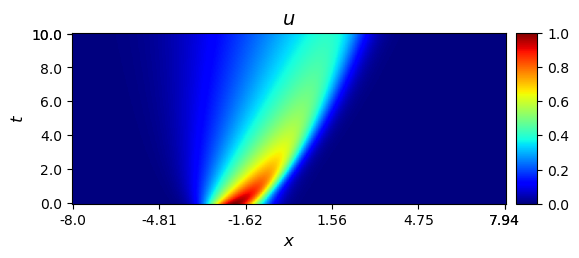

In [39]:

fig, ax = plt.subplots(1,figsize=(6,8))
ax1 = ax
im1 = ax1.imshow(u_soln_new.T,cmap='jet',origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xlabel('$x$',fontsize=12)
ax1.set_ylabel('$t$',fontsize=12)
ax1.set_xticks(xpoints_n)
ax1.set_xticklabels(x_label_list_n)
ax1.set_yticks(ypoints_n)
ax1.set_yticklabels(y_label_list_n)
ax1.set_title('$u$',fontsize=14)
plt.show()

In [40]:
normalization_layer_new = tp.models.NormalizationLayer(I_new*Omega_new)
fcn_layer_new = tp.models.FCN(input_space=T_new*X_new, output_space=U_new, hidden = (128,128,128))
model_sol_new = tp.models.Sequential(normalization_layer_new, fcn_layer_new)

In [41]:
N_coll_new = 10000

In [42]:
domain_sampler_new = tp.samplers.RandomUniformSampler(I_new*Omega_new, n_points=N_coll_new)

In [43]:
def quantities_new(t, x):
    
    model_input = tp.spaces.Points(torch.column_stack((t, x)), T_new*X_new)
    u = model_sol_new(model_input)
    u = u.as_tensor
    grad_u_x = tp.utils.grad(u, x) 
    grad_u_xx = tp.utils.grad(grad_u_x, x) 
    grad_u_t = tp.utils.grad(u, t) 
    
    return u, grad_u_t, grad_u_x, grad_u_xx     


def residual_equation_new(t,x):
    
    u, grad_u_t, grad_u_x, grad_u_xx  = quantities_new(t,x)
    
    output_hid_phy = hiddenPhysics(u, grad_u_x, grad_u_xx) 
    
    residual = grad_u_t - output_hid_phy
    
    
    return residual 

In [44]:
pde_condition_new  = tp.conditions.PINNCondition(module = model_sol_new, 
                                                 sampler = domain_sampler_new,
                                                 residual_fn = residual_equation_new, 
                                                 name='PDE Condition',
                                                 weight=1.0)


In [45]:
N_ic = 250
initial_sampler_new = tp.samplers.RandomUniformSampler(I_new.boundary_left*Omega_new, n_points=N_ic)

def residual_IC(u,t,x):
    
    return -torch.exp(-(x + 2)**2) + u


initial_condition_new  = tp.conditions.PINNCondition(module = model_sol_new, 
                                                 sampler = initial_sampler_new,
                                                 residual_fn = residual_IC, 
                                                 name='Initial Condition',
                                                 weight=1.0)

In [46]:

def residual_BC(u_left,u_right,x_left,x_right):
       
    u_x_left = tp.utils.grad(u_left, x_left)
    u_x_right = tp.utils.grad(u_right, x_right)
    
    error_u_neumann = u_left - u_right
    error_u_x_neumann = u_x_left - u_x_right
    
    return error_u_neumann + error_u_x_neumann

N_bc = 500
boundary_sampler_new = tp.samplers.RandomUniformSampler(I_new, n_points=N_bc)

bound_condition_new = tp.conditions.PeriodicCondition(module=model_sol_new,
                                             periodic_interval=Omega_new,
                                             non_periodic_sampler=boundary_sampler_new,
                                             residual_fn=residual_BC,
                                             name='Boundary Condition', 
                                             weight=1.0)

In [47]:
training_conditions_new = [initial_condition_new,pde_condition_new,bound_condition_new]
optim_new = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver_new = tp.solver.Solver(train_conditions=training_conditions_new, optimizer_setting=optim_new)


In [48]:
epochs = 2500
trainer_new = pl.Trainer(gpus=0, 
                     max_steps=epochs, 
                     logger=True,
                     benchmark=True,
)                  
trainer_new.fit(solver_new) 

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/setup.py:179: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 33.5 K
1 | val_conditions   | ModuleList | 0     
---------------------

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 0: 100%|█████████▉| 2500/2501 [03:12<00:00, 13.01it/s, loss=0.000477, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2501/2501 [03:12<00:00, 13.01it/s, loss=0.000477, v_num=1]

`Trainer.fit` stopped: `max_steps=2500` reached.


Epoch 0: 100%|██████████| 2501/2501 [03:12<00:00, 13.01it/s, loss=0.000477, v_num=1]


In [49]:
u_pred_new = model_sol_new(input_data_new)

In [50]:
u_pred_new = u_pred_new.as_tensor.detach().numpy()
u_pred_new = u_pred_new.reshape(XX_new.shape)

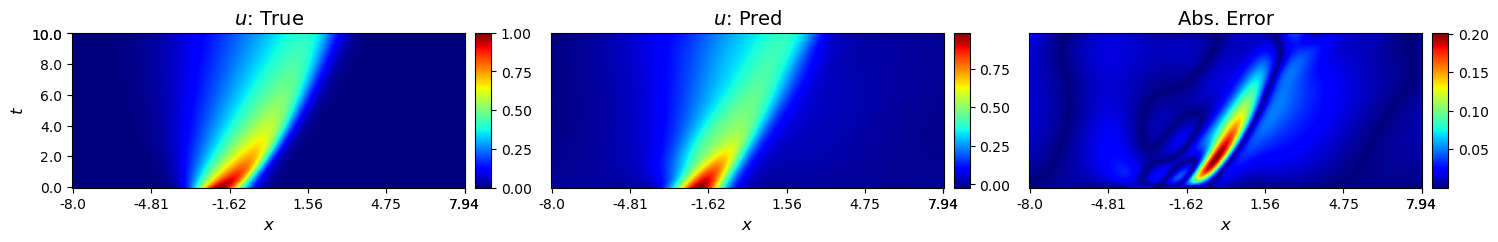

In [51]:
cmap = 'jet'#'seismic'
plt.figure(figsize=(15,6))
ax1 = plt.subplot(131)
im1 = ax1.imshow(u_soln_new.T,cmap=cmap,origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='4%', pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xlabel('$x$',fontsize=12)
ax1.set_ylabel('$t$',fontsize=12)
ax1.set_xticks(xpoints_n)
ax1.set_xticklabels(x_label_list_n)
ax1.set_yticks(ypoints_n)
ax1.set_yticklabels(y_label_list_n)
ax1.set_title('$u$: True',fontsize=14)

ax2 = plt.subplot(132)
im2 = ax2.imshow(u_pred_new.T,cmap=cmap,origin='lower')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='4%', pad=0.1)
plt.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_xlabel('$x$',fontsize=12)
#ax2.set_ylabel('$t$',fontsize=12)
ax2.set_xticks(xpoints_n)
ax2.set_xticklabels(x_label_list_n)
ax2.set_yticks(ypoints_n)
ax2.set_yticklabels(y_label_list_n)
ax2.tick_params(left = False, labelleft = False) 
ax2.set_title('$u$: Pred',fontsize=14)

ax3 = plt.subplot(133)
im3 = ax3.imshow(np.abs(u_soln_new.T - u_pred_new.T),cmap=cmap,origin='lower')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='4%', pad=0.1)
plt.colorbar(im3, cax=cax, orientation='vertical')
ax3.set_xlabel('$x$',fontsize=12)
#ax3.set_ylabel('$t$',fontsize=12)
ax3.set_xticks(xpoints_n)
ax3.set_xticklabels(x_label_list_n)
ax3.set_yticks(ypoints_n)
ax3.set_yticklabels(y_label_list_n)
ax3.set_title('Abs. Error',fontsize=14)
ax3.tick_params(left = False, labelleft = False) 
plt.tight_layout()
plt.show()



In [52]:
l2_error_u_new = L2_ERROR(u_soln_new.flatten(),u_pred_new.flatten())
r2_score_u_new = R2_SCORE(u_soln_new.flatten(),u_pred_new.flatten())
print('L2 Error u: ', l2_error_u_new)
print('R2 Score u: ', r2_score_u_new)

L2 Error u:  0.13872807530454387
R2 Score u:  0.9735773288509157
